In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# NLP From Scratch: Classifying Names with a Character-Level RNN
**Author**: [Sean Robertson](https://github.com/spro)

We will be building and training a basic character-level Recurrent Neural
Network (RNN) to classify words. This tutorial, along with two other
Natural Language Processing (NLP) "from scratch" tutorials
:doc:`/intermediate/char_rnn_generation_tutorial` and
:doc:`/intermediate/seq2seq_translation_tutorial`, show how to
preprocess data to model NLP. In particular these tutorials do not
use many of the convenience functions of `torchtext`, so you can see how
preprocessing to model NLP works at a low level.

A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


## Recommended Preparation

Before starting this tutorial it is recommended that you have installed PyTorch,
and have a basic understanding of Python programming language and Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
   and learn the basics of Tensors
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   is about LSTMs specifically but also informative about RNNs in
   general

## Preparing the Data

.. Note::
   Download the data from
   [here](https://download.pytorch.org/tutorial/data.zip)
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
``[Language].txt``. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.


In [ ]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('sample_data/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['sample_data/German.txt', 'sample_data/English.txt', 'sample_data/Irish.txt', 'sample_data/French.txt', 'sample_data/Spanish.txt', 'sample_data/Dutch.txt', 'sample_data/Chinese.txt', 'sample_data/Polish.txt', 'sample_data/Russian.txt', 'sample_data/Greek.txt', 'sample_data/Scottish.txt', 'sample_data/Czech.txt', 'sample_data/Portuguese.txt', 'sample_data/Italian.txt', 'sample_data/Vietnamese.txt', 'sample_data/Japanese.txt', 'sample_data/Korean.txt', 'sample_data/Arabic.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [ ]:
print(category_lines['Italian'][:5])

KeyError: ignored

In [ ]:
category_lines['English'][:5]

KeyError: ignored

### Turning Names into Tensors

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Creating the Network

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from [the PyTorch for Torch users
tutorial](https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net)_)
is just 2 linear layers which operate on an input and hidden state, with
a ``LogSoftmax`` layer after the output.




In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
##lstm

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sigma=0.1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
#         self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(input_size, hidden_size),
                          init_weight(hidden_size, hidden_size),
                          nn.Parameter(torch.zeros(hidden_size)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self, inputs, H_C=None):
#         combined = torch.cat((input, hidden), 1)
#         hidden = self.i2h(combined)
#         output = self.h2o(hidden)
#         output = self.softmax(output)
        if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens))
            C = torch.zeros((inputs.shape[1], self.num_hiddens))
        else:
            H, C = H_C
        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                            torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                            torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                            torch.matmul(H, self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                               torch.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        ys=self.h2o(H)
        y=self.softmax(ys)
        return y,(H,C)
        #return outputs, (H, C)
        #return output, hidden

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size),torch.zeros(1, self.hidden_size))

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

In [ ]:
import torch
import torch.nn as nn

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.0, sigma=0.1):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Linear layer for the output
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Softmax layer for the output
        self.softmax = nn.LogSoftmax(dim=1)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)

        # Function to initialize weights
        def init_weight(*shape):
            return nn.Parameter(torch.randn(*shape) * sigma)

        # Helper function to create gate parameters
        def create_gate_parameters():
            return (init_weight(input_size, hidden_size),
                    init_weight(hidden_size, hidden_size),
                    nn.Parameter(torch.zeros(hidden_size)))

        # Parameters for the input, forget, output gates and cell state
        self.W_xi, self.W_hi, self.b_i = create_gate_parameters()  # Input gate
        self.W_xf, self.W_hf, self.b_f = create_gate_parameters()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = create_gate_parameters()  # Output gate
        self.W_xc, self.W_hc, self.b_c = create_gate_parameters()  # Cell state

    def forward(self, inputs, initial_state=None):
        if initial_state is None:
            # Initial states for hidden and cell state
            hidden_state = torch.zeros((inputs.shape[1], self.hidden_size))
            cell_state = torch.zeros((inputs.shape[1], self.hidden_size))
        else:
            hidden_state, cell_state = initial_state

        outputs = []
        for X in inputs:
            # Calculating gate activations
            input_gate = torch.sigmoid(torch.matmul(X, self.W_xi) + torch.matmul(hidden_state, self.W_hi) + self.b_i)
            forget_gate = torch.sigmoid(torch.matmul(X, self.W_xf) + torch.matmul(hidden_state, self.W_hf) + self.b_f)
            output_gate = torch.sigmoid(torch.matmul(X, self.W_xo) + torch.matmul(hidden_state, self.W_ho) + self.b_o)
            cell_candidates = torch.tanh(torch.matmul(X, self.W_xc) + torch.matmul(hidden_state, self.W_hc) + self.b_c)

            # Updating cell state and hidden state
            cell_state = forget_gate * cell_state + input_gate * cell_candidates
            hidden_state = output_gate * torch.tanh(cell_state)

            # Applying dropout to hidden state
            hidden_state_dropout = self.dropout(hidden_state)
            outputs.append(hidden_state_dropout)

        # Compute the output
        final_output = self.output_linear(hidden_state_dropout)
        output_softmax = self.softmax(final_output)
        return output_softmax, (hidden_state, cell_state)

    def initHidden(self):
        # Initialize hidden and cell states to zeros
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))

# params of the LSTM
n_hidden = 128
lstm = CustomLSTM(n_letters, n_hidden, n_categories, dropout_rate=0.2)


To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [ ]:
input = letterToTensor('A')
hidden = (torch.zeros(1, n_hidden),torch.zeros(1, n_hidden))

output, next_hidden = lstm(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
precomputing batches of Tensors.




In [ ]:
input = lineToTensor('Albert')
hidden = (torch.zeros(1, n_hidden),torch.zeros(1, n_hidden))

output, next_hidden = lstm(input[0], hidden)
print(output)

tensor([[-2.9062, -2.9210, -2.8167, -2.9318, -2.8783, -2.9401, -2.8767, -2.8277,
         -2.8232, -2.9179, -2.9943, -2.8985, -2.8444, -2.9082, -2.9477, -2.9107,
         -2.8980, -2.8072]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
output.shape, output

(torch.Size([1, 18]),
 tensor([[-2.9062, -2.9210, -2.8167, -2.9318, -2.8783, -2.9401, -2.8767, -2.8277,
          -2.8232, -2.9179, -2.9943, -2.8985, -2.8444, -2.9082, -2.9477, -2.9107,
          -2.8980, -2.8072]], grad_fn=<LogSoftmaxBackward0>))

In [ ]:
next_hidden

(tensor([[-0.0338, -0.0094,  0.0178, -0.0054, -0.0430, -0.0143, -0.0283, -0.0189,
          -0.0125,  0.0054, -0.0087, -0.0181, -0.0065, -0.0206, -0.0248, -0.0271,
           0.0141,  0.0291, -0.0265, -0.0251, -0.0474,  0.0211,  0.0137, -0.0207,
          -0.0183,  0.0167,  0.0220,  0.0260, -0.0046,  0.0065, -0.0319, -0.0017,
          -0.0460, -0.0108,  0.0400,  0.0146, -0.0239,  0.0032,  0.0067,  0.0066,
           0.0415, -0.0195, -0.0595,  0.0205,  0.0179, -0.0640,  0.0391,  0.0022,
          -0.0310, -0.0176,  0.0382,  0.0180,  0.0271,  0.0250,  0.0315,  0.0086,
           0.0415,  0.0185,  0.0117,  0.0416, -0.0288, -0.0323,  0.0261, -0.0572,
          -0.0170, -0.0493,  0.0156, -0.0286, -0.0193,  0.0008, -0.0797, -0.0120,
           0.0641,  0.0064,  0.0229, -0.0158,  0.0125,  0.0206, -0.0127, -0.0312,
           0.0266, -0.0132, -0.0193,  0.0072, -0.0204, -0.0320, -0.0008,  0.0330,
           0.0098, -0.0111,  0.0324, -0.0176, -0.0146, -0.0169, -0.0019,  0.0190,
          -0.002

As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




## Training
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 17)


We will also want a quick way to get a training example (a name and its
language):




In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Santos
category = Chinese / line = Chin
category = Irish / line = Cassidy
category = Scottish / line = Muir
category = French / line = Chevalier
category = French / line = Lavigne
category = Czech / line = Kopp
category = Scottish / line = Stewart
category = Czech / line = Cervenka
category = Japanese / line = Takaki


### Training the Network

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = lstm.initHidden()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 13s) 2.8087 Sun / Korean ✓
10000 10% (0m 27s) 2.8663 Broz / Portuguese ✗ (Polish)
15000 15% (0m 41s) 2.8546 Tzenin / Dutch ✗ (Russian)
20000 20% (0m 55s) 2.8694 Quraishi / Greek ✗ (Arabic)
25000 25% (1m 8s) 2.4800 Carideo / Spanish ✗ (Italian)
30000 30% (1m 22s) 2.0459 Crespo / Spanish ✗ (Portuguese)
35000 35% (1m 36s) 2.2641 Payne / Irish ✗ (English)
40000 40% (1m 49s) 2.3447 Abadi / Italian ✗ (Arabic)
45000 45% (2m 3s) 1.1619 Mcmahon / Irish ✓
50000 50% (2m 16s) 1.7267 Shamon / Irish ✗ (Arabic)
55000 55% (2m 30s) 0.1869 Krakowski / Polish ✓
60000 60% (2m 44s) 0.9170 Sook / Korean ✓
65000 65% (2m 58s) 2.3452 Heinrichs / Dutch ✗ (German)
70000 70% (3m 12s) 1.0827 Morek / Polish ✗ (Czech)
75000 75% (3m 26s) 0.8028 Luu / Vietnamese ✓
80000 80% (3m 40s) 0.0976 Sokolsky / Polish ✓
85000 85% (3m 54s) 0.5896 Yasui / Japanese ✓
90000 90% (4m 8s) 1.8218 Geiger / French ✗ (German)
95000 95% (4m 22s) 0.2093 Szwedko / Polish ✓
100000 100% (4m 36s) 2.1519 Altham / Scottish ✗ (English)


### Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network
learning:




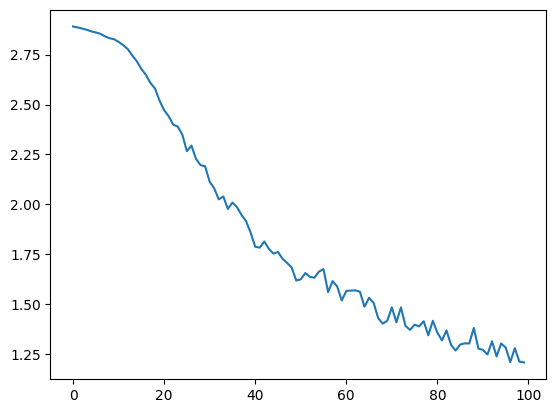

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Accuracy   : 0.5955


/var/folders/pg/88t62z716tx4bc3mxmsldm5r0000gn/T/ipykernel_17006/625028700.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/pg/88t62z716tx4bc3mxmsldm5r0000gn/T/ipykernel_17006/625028700.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


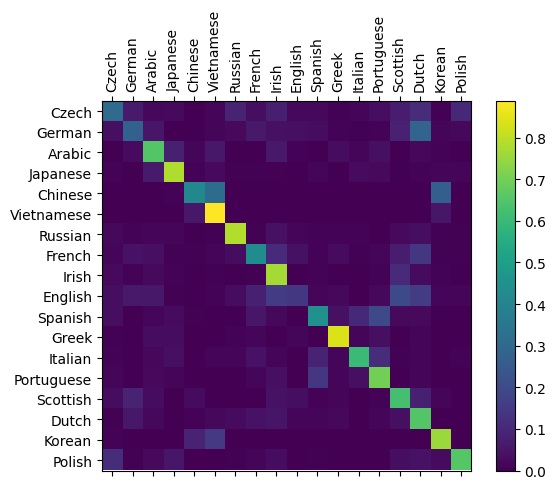

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    return output

y_test=[]
y_pred=[]

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    y_test.append(category)
    y_pred.append(guess)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)



# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
confusion.diagonal()/confusion.sum(axis=1)

tensor([0.3152, 0.2990, 0.6418, 0.7849, 0.4353, 0.8555, 0.7822, 0.4026, 0.7745,
        0.1590, 0.4320, 0.8440, 0.6259, 0.7346, 0.6354, 0.6846, 0.7491, 0.6515])

In [ ]:
sum(confusion.diagonal()/confusion.sum(axis=1))

tensor(10.8072)

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




### Running on User Input




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.90) Russian
(-0.91) Czech
(-2.12) Polish

> Jackson
(-0.96) Russian
(-1.05) English
(-1.65) Scottish

> Satoshi
(-0.74) Japanese
(-1.49) Arabic
(-1.89) Italian


The final versions of the scripts [in the Practical PyTorch
repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)_
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with ``bottle.py``)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




## Exercises

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


